### Import

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
from pybiomart import Server
from statsmodels import robust

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import kneighbors_graph
from networkx.algorithms.community.quality import modularity
import networkx as nx
from tqdm.auto import tqdm

#### Manually create df for hypertuning results from tSNE_tuning.ipynb

In [3]:
columns = [
    'perplexity',
    'learning_rate',
    'max_iter',
    'early_exaggeration',
    'init',
    'metric',
    'eps',
    'DBSCAN silhouette_score',
    'DBSCAN modularity',
    'KMEANS silhouette_score',
    'KMEANS modularity'
]

# Create an empty DataFrame with these columns
results_df = pd.DataFrame(columns=columns)

optimal_parameters = [
    [5, 500, 1000, 8, 'pca', 'correlation', 0.5, 0.44063088297843933, 0.4532942315917817, 0.37313687801361084, 0.753825218902045], 
    [5, 500, 1000, 8, 'pca', 'correlation', 3.0, 0.6847063302993774, 0.4532942315917817, 0.37313687801361084, 0.753825218902045], 
    [5, 500, 1000, 8, 'pca', 'correlation', 5.0, 0.5032649636268616, 0.4532942315917817, 0.37313687801361084, 0.753825218902045],
    [10, 200, 2000, 16, 'random', 'correlation', 0.5, 0.30841779708862305, 0.42127604166666666, 0.4202597439289093, 0.7557198629136488], 
    [10, 200, 2000, 16, 'random', 'correlation', 3.0, 0.6059994101524353, 0.42127604166666666, 0.4202597439289093, 0.7557198629136488], 
    [10, 200, 2000, 16, 'random', 'correlation', 5.0, 0.20487459003925323, 0.42127604166666666, 0.4202597439289093, 0.7557198629136488],
    [5, 500, 2000, 16, 'random', 'correlation', 3.0, 0.8643698692321777, 0.4122498463219726, 0.4001385569572449, 0.7415797596265971],
    [5, 500, 2000, 8, 'random', 'cosine', 0.5, 0.528999924659729, 0.4503998942751977, 0.45971161127090454, 0.7478229205624486], 
    [5, 500, 2000, 8, 'random', 'cosine', 3.0, 0.8149074912071228, 0.4503998942751977, 0.45971161127090454, 0.7478229205624486], 
    [5, 500, 2000, 8, 'random', 'cosine', 5.0, 0.5501605272293091, 0.4503998942751977, 0.45971161127090454, 0.7478229205624486]
    
]

results_df = pd.concat([
    results_df,
    pd.DataFrame(optimal_parameters, columns=results_df.columns)
], ignore_index=True)


/var/folders/jm/5vzzqzhj11sf3b5cll9hy6r80000gn/T/ipykernel_83345/2137663952.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([


In [5]:
# Note that epsilon is not a hyperparameter for KMEANS (so it will have duplicate entries)
results_df

,perplexity,learning_rate,max_iter,early_exaggeration,init,metric,eps,DBSCAN silhouette_score,DBSCAN modularity,KMEANS silhouette_score,KMEANS modularity
0,5,500,1000,8,pca,correlation,0.5,0.440631,0.453294,0.373137,0.753825
1,5,500,1000,8,pca,correlation,3.0,0.684706,0.453294,0.373137,0.753825
2,5,500,1000,8,pca,correlation,5.0,0.503265,0.453294,0.373137,0.753825
3,10,200,2000,16,random,correlation,0.5,0.308418,0.421276,0.420260,0.755720
4,10,200,2000,16,random,correlation,3.0,0.605999,0.421276,0.420260,0.755720
5,10,200,2000,16,random,correlation,5.0,0.204875,0.421276,0.420260,0.755720
6,5,500,2000,16,random,correlation,3.0,0.864370,0.412250,0.400139,0.741580
7,5,500,2000,8,random,cosine,0.5,0.529000,0.450400,0.459712,0.747823
8,5,500,2000,8,random,cosine,3.0,0.814907,0.450400,0.459712,0.747823
9,5,500,2000,8,random,cosine,5.0,0.550161,0.450400,0.459712,0.747823


### Preprocess

In [6]:
raw_expression = pd.read_csv('Team_4_STAD/TCGA.STAD.expression.txt', sep='\t')
metadata = pd.read_csv('Team_4_STAD/TCGA.STAD.metadata.txt', sep='\t')

id_cols = raw_expression.iloc[:, :2]

### Drop unknown HUGO genes
columns_to_drop = [col for col in raw_expression.columns if "?" in col]
raw_expression = raw_expression.drop(columns=columns_to_drop, axis=1)
# raw_expression.shape[1]
expression_values = raw_expression.iloc[:, 2:]

# Impute missing values
imputer = KNNImputer(n_neighbors=5)
imputed_expression = imputer.fit_transform(expression_values)

log2_expression = np.log2(imputed_expression + 1) # add 2 instead of 1?

gene_means = log2_expression.mean(axis=0)
gene_vars = log2_expression.var(axis=0)
gene_mads = np.apply_along_axis(robust.mad, axis=0, arr=log2_expression)

# Drop genes with low expression & variance
mean_threshold = 1
#var_threshold = 0.7
var_threshold = np.percentile(gene_vars, 20)
mad_threshold = np.median(gene_mads)

keep_genes = (gene_means > mean_threshold) & (gene_vars > var_threshold) & (gene_mads > mad_threshold)
filtered_expression = log2_expression[:, keep_genes]

scaler = StandardScaler()
scaled_expression = scaler.fit_transform(filtered_expression)
scaled_expression.shape[1]

9807

### Optimal Modularity & Silhouette Scores for DBSCAN and KMEANS


In [8]:
# Note that best_hbdbscan_* variable was not renamed for kmeans
best_dbscan_mod = results_df[results_df['DBSCAN modularity'] == results_df['DBSCAN modularity'].max()]
best_dbscan_mod.reset_index(drop=True, inplace=True)

best_hdbscan_mod = results_df[results_df['KMEANS modularity'] == results_df['KMEANS modularity'].max()]
best_hdbscan_mod.reset_index(drop=True, inplace=True)

best_dbscan_sil = results_df[results_df['DBSCAN silhouette_score'] == results_df['DBSCAN silhouette_score'].max()]
best_dbscan_sil.reset_index(drop=True, inplace=True)

best_hdbscan_sil = results_df[results_df['KMEANS silhouette_score'] == results_df['KMEANS silhouette_score'].max()]
best_hdbscan_sil.reset_index(drop=True, inplace=True)

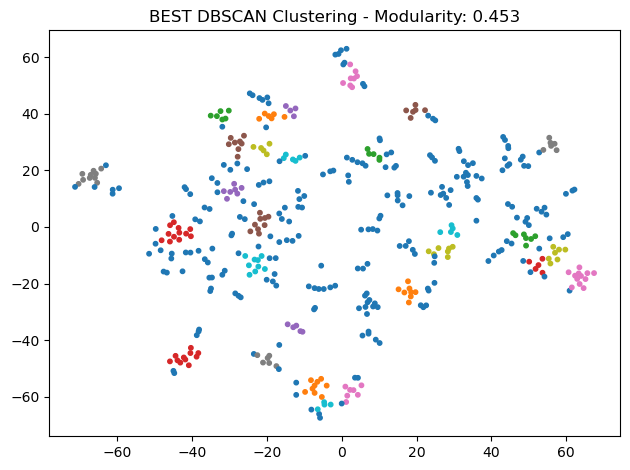

In [9]:
## BEST DBSCAN MODULARITY
tsne = TSNE(n_components=2, perplexity=best_dbscan_mod.loc[0,'perplexity'], learning_rate=best_dbscan_mod.loc[0,'learning_rate'], max_iter=best_dbscan_mod.loc[0,'max_iter'], init=best_dbscan_mod.loc[0,'init'], metric=best_dbscan_mod.loc[0,'metric'], early_exaggeration=best_dbscan_mod.loc[0,'early_exaggeration'], random_state=42)
tsne_embedding = tsne.fit_transform(scaled_expression)

# Make into a DataFrame and re-attach IDs
tsne_df = pd.DataFrame(tsne_embedding, columns=['tSNE-1', 'tSNE-2'])
tsne_df = pd.concat([id_cols.reset_index(drop=True), tsne_df], axis=1)

dbscan = DBSCAN(eps=3, min_samples=5)
dbscan_labels = dbscan.fit_predict(tsne_embedding)

plt.scatter(tsne_embedding[:,0], tsne_embedding[:,1], c=dbscan_labels, cmap='tab10', s=10)
value = best_dbscan_mod.loc[0,'DBSCAN modularity']
plt.title(f"BEST DBSCAN Clustering - Modularity: {value:.3f}")

plt.tight_layout()
plt.show()

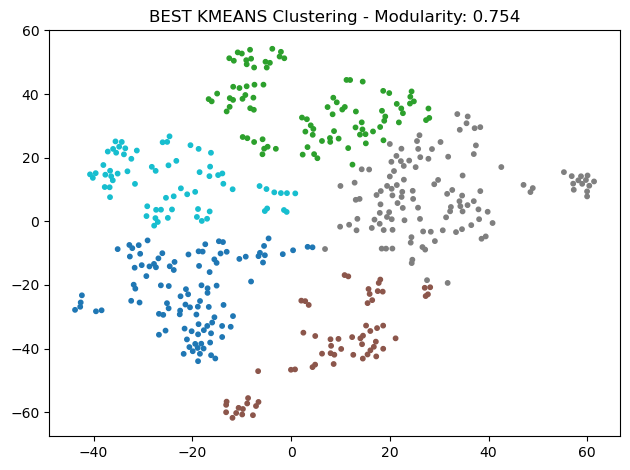

In [10]:
## BEST KMEANS MODULARITY
tsne = TSNE(n_components=2, perplexity=best_hdbscan_mod.loc[0,'perplexity'], learning_rate=best_hdbscan_mod.loc[0,'learning_rate'], max_iter=best_hdbscan_mod.loc[0,'max_iter'], init=best_hdbscan_mod.loc[0,'init'], metric=best_hdbscan_mod.loc[0,'metric'], early_exaggeration=best_hdbscan_mod.loc[0,'early_exaggeration'], random_state=42)
tsne_embedding = tsne.fit_transform(scaled_expression)

# Make into a DataFrame and re-attach IDs
tsne_df = pd.DataFrame(tsne_embedding, columns=['tSNE-1', 'tSNE-2'])
tsne_df = pd.concat([id_cols.reset_index(drop=True), tsne_df], axis=1)

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(tsne_embedding)

plt.scatter(tsne_embedding[:,0], tsne_embedding[:,1], c=kmeans_labels, cmap='tab10', s=10)
value = best_dbscan_mod.loc[0,'KMEANS modularity']
plt.title(f"BEST KMEANS Clustering - Modularity: {value:.3f}")

plt.tight_layout()
plt.show()

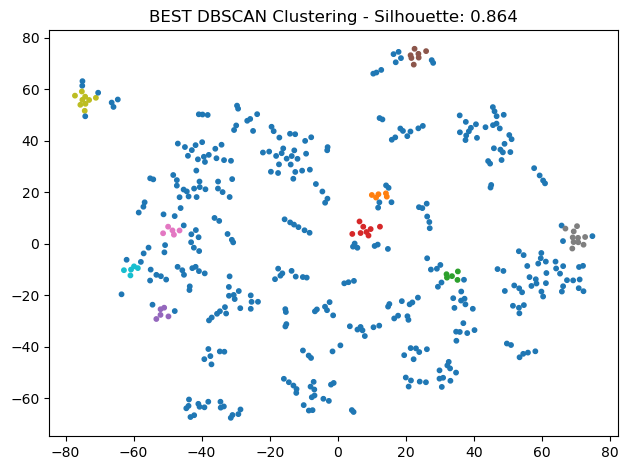

In [11]:
## BEST DBSCAN SILHOUETTE
tsne = TSNE(n_components=2, perplexity=best_dbscan_sil.loc[0,'perplexity'], learning_rate=best_dbscan_sil.loc[0,'learning_rate'], max_iter=best_dbscan_sil.loc[0,'max_iter'], init=best_dbscan_sil.loc[0,'init'], metric=best_dbscan_sil.loc[0,'metric'], early_exaggeration=best_dbscan_sil.loc[0,'early_exaggeration'], random_state=42)
tsne_embedding = tsne.fit_transform(scaled_expression)

# Make into a DataFrame and re-attach IDs
tsne_df = pd.DataFrame(tsne_embedding, columns=['tSNE-1', 'tSNE-2'])
tsne_df = pd.concat([id_cols.reset_index(drop=True), tsne_df], axis=1)

dbscan = DBSCAN(eps=3, min_samples=5)
dbscan_labels = dbscan.fit_predict(tsne_embedding)

plt.scatter(tsne_embedding[:,0], tsne_embedding[:,1], c=dbscan_labels, cmap='tab10', s=10)
value = best_dbscan_sil.loc[0,'DBSCAN silhouette_score']
plt.title(f"BEST DBSCAN Clustering - Silhouette: {value:.3f}")

plt.tight_layout()
plt.show()

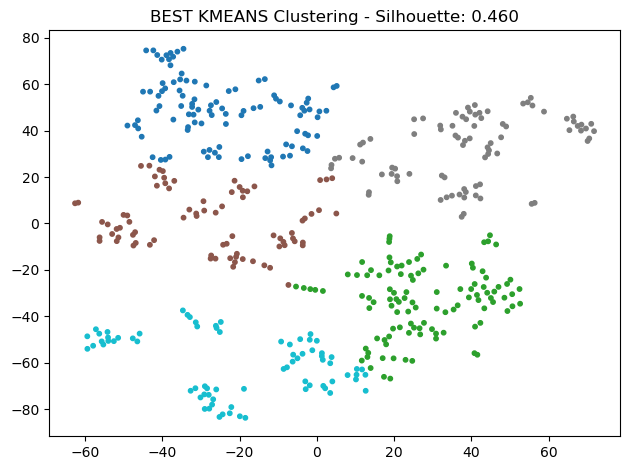

In [12]:
## BEST KMEANS SILHOUETTE
tsne = TSNE(n_components=2, perplexity=best_hdbscan_sil.loc[0,'perplexity'], learning_rate=best_hdbscan_sil.loc[0,'learning_rate'], max_iter=best_hdbscan_sil.loc[0,'max_iter'], init=best_hdbscan_sil.loc[0,'init'], metric=best_hdbscan_sil.loc[0,'metric'], early_exaggeration=best_hdbscan_sil.loc[0,'early_exaggeration'], random_state=42)
tsne_embedding = tsne.fit_transform(scaled_expression)

# Make into a DataFrame and re-attach IDs
tsne_df = pd.DataFrame(tsne_embedding, columns=['tSNE-1', 'tSNE-2'])
tsne_df = pd.concat([id_cols.reset_index(drop=True), tsne_df], axis=1)

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(tsne_embedding)

plt.scatter(tsne_embedding[:,0], tsne_embedding[:,1], c=kmeans_labels, cmap='tab10', s=10)
value = best_hdbscan_sil.loc[0,'KMEANS silhouette_score']
plt.title(f"BEST KMEANS Clustering - Silhouette: {value:.3f}")

plt.tight_layout()
plt.show()